<a href="https://colab.research.google.com/github/Julia-Vanyarina/6_1/blob/main/6_1ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
from google.colab import files
uploaded = files.upload()

Saving pageview_counts_202504061121.csv to pageview_counts_202504061121 (1).csv


In [36]:
df = pd.read_csv('pageview_counts_202504061121.csv')
df['datetime'] = pd.to_datetime(df['datetime'])

In [37]:
df.head()

,pagename,pageviewcount,datetime
0,Apple,71,2025-02-04 00:00:00
1,Apple,48,2025-02-04 01:00:00
2,Apple,39,2025-02-04 02:00:00
3,Apple,39,2025-02-04 03:00:00
4,Apple,42,2025-02-04 04:00:00


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938 entries, 0 to 937
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   pagename       938 non-null    object        
 1   pageviewcount  938 non-null    int64         
 2   datetime       938 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 22.1+ KB


In [39]:
df.describe()

,pageviewcount,datetime
count,938.00000,938
mean,53.83049,2025-02-23 14:29:36.972281600
min,17.00000,2025-02-04 00:00:00
25%,37.00000,2025-02-13 18:15:00
50%,47.00000,2025-02-23 13:30:00
75%,68.00000,2025-03-05 10:45:00
max,196.00000,2025-03-15 07:00:00
std,23.50667,NaN


Предобработка данных:
Всего строк: 1440
Период данных: с 2025-02-04 00:00:00 по 2025-04-04 23:00:00
Пропуски:
pagename         0
pageviewcount    0
datetime         0
dtype: int64


<ipython-input-32-57f610b8d49f>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='date', y='total_views', data=top_days, palette='viridis')


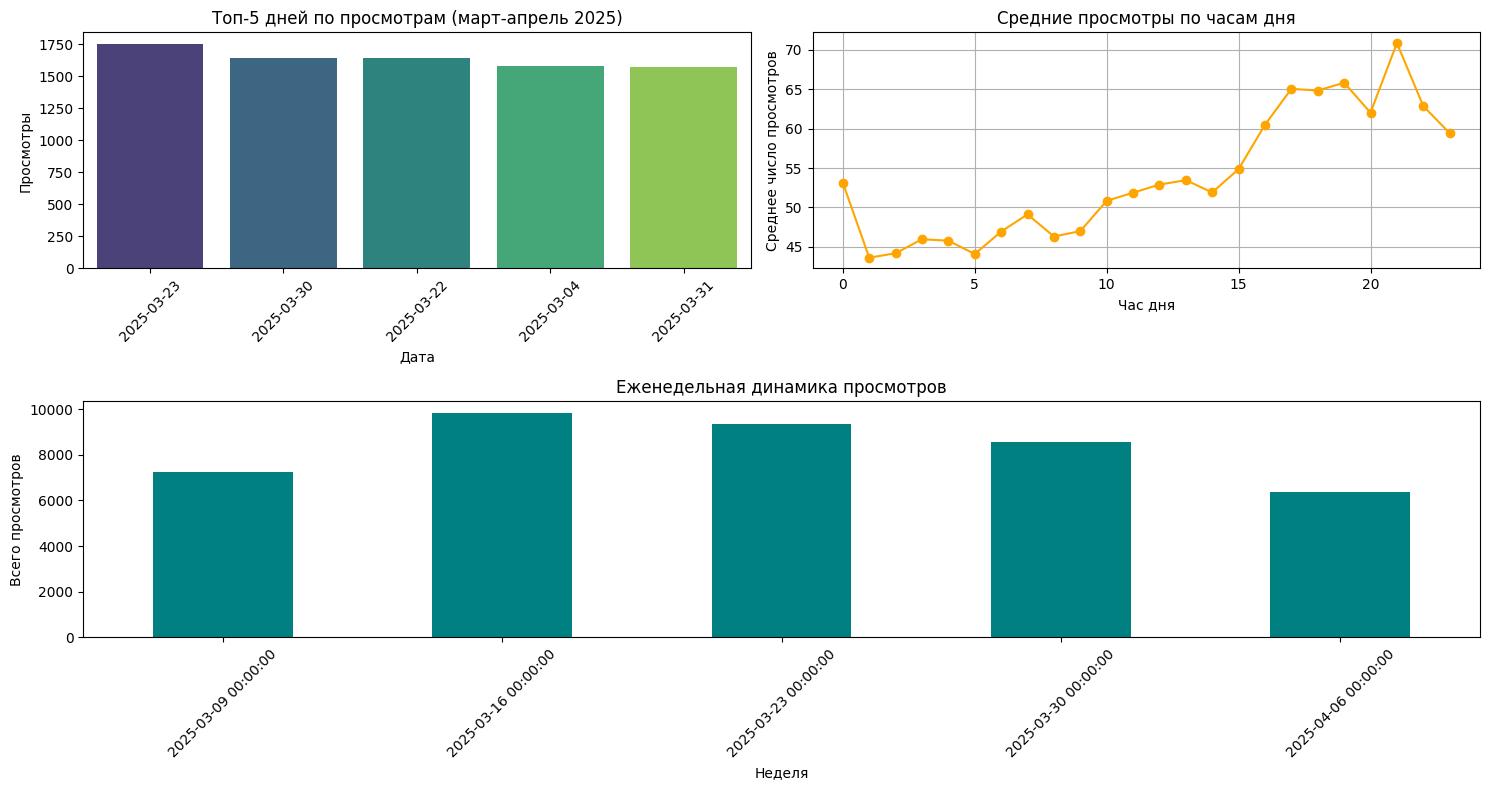


Анализ данных за последний месяц:
Среднее число просмотров в день: 1293.5
Максимальное число просмотров за день: 1757
Минимальное число просмотров за день: 788
Самый популярный час: 21:00 - 70.9 просмотров


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


print("Предобработка данных:")
print(f"Всего строк: {len(df)}")
print(f"Период данных: с {df['datetime'].min()} по {df['datetime'].max()}")
print(f"Пропуски:\n{df.isnull().sum()}")


last_month = df[df['datetime'] >= datetime(2025, 3, 4)]

# Группировка по дням для анализа
daily_views = last_month.groupby(last_month['datetime'].dt.date)['pageviewcount'].sum().reset_index()
daily_views.columns = ['date', 'total_views']


plt.figure(figsize=(15, 8))

#Топ-5 дней с наибольшим числом просмотров (последний месяц)
top_days = daily_views.nlargest(5, 'total_views')
plt.subplot(2, 2, 1)
sns.barplot(x='date', y='total_views', data=top_days, palette='viridis')
plt.title('Топ-5 дней по просмотрам (март-апрель 2025)')
plt.xlabel('Дата')
plt.ylabel('Просмотры')
plt.xticks(rotation=45)

#Распределение просмотров по часам
plt.subplot(2, 2, 2)
hourly_pattern = last_month.groupby(last_month['datetime'].dt.hour)['pageviewcount'].mean()
hourly_pattern.plot(kind='line', marker='o', color='orange')
plt.title('Средние просмотры по часам дня')
plt.xlabel('Час дня')
plt.ylabel('Среднее число просмотров')
plt.grid()

#Еженедельная динамика
plt.subplot(2, 1, 2)
weekly_views = last_month.resample('W', on='datetime')['pageviewcount'].sum()
weekly_views.plot(kind='bar', color='teal')
plt.title('Еженедельная динамика просмотров')
plt.xlabel('Неделя')
plt.ylabel('Всего просмотров')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('pageviews_analysis.png', dpi=300)
plt.show()

# Результаты
print("\nАнализ данных за последний месяц:")
print(f"Среднее число просмотров в день: {daily_views['total_views'].mean():.1f}")
print(f"Максимальное число просмотров за день: {daily_views['total_views'].max()}")
print(f"Минимальное число просмотров за день: {daily_views['total_views'].min()}")
print(f"Самый популярный час: {hourly_pattern.idxmax()}:00 - {hourly_pattern.max():.1f} просмотров")

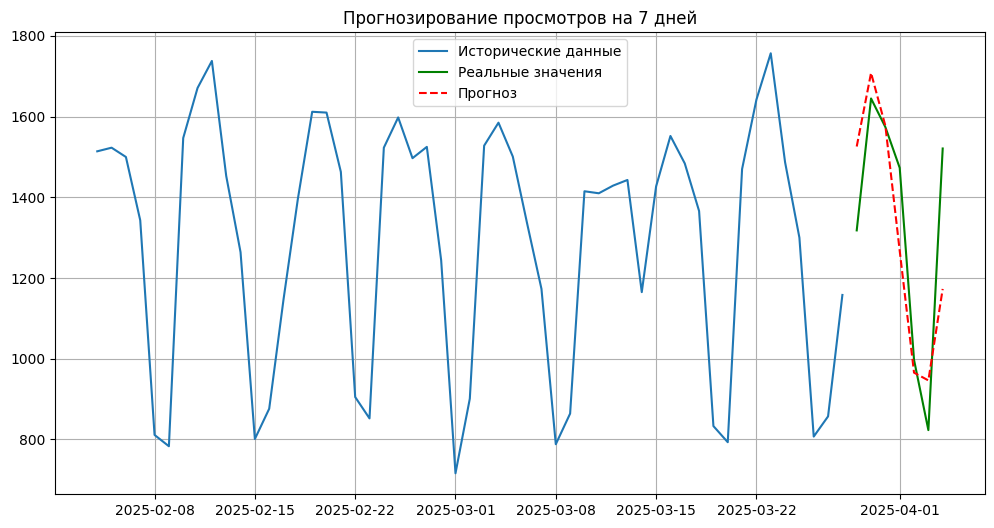

In [34]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

daily_data = df.resample('D', on='datetime')['pageviewcount'].sum()

train_data = daily_data[:-7].values.astype(float)
test_data = daily_data[-7:].values.astype(float)

try:
    model = ARIMA(train_data, order=(7, 0, 1))
    model_fit = model.fit()

    # Прогнозирование
    forecast = model_fit.forecast(steps=7)

    # Визуализация
    plt.figure(figsize=(12, 6))
    plt.plot(daily_data.index[:-7], train_data, label='Исторические данные')
    plt.plot(daily_data.index[-7:], test_data, label='Реальные значения', color='green')
    plt.plot(daily_data.index[-7:], forecast, label='Прогноз', linestyle='--', color='red')
    plt.title('Прогнозирование просмотров на 7 дней')
    plt.legend()
    plt.grid()
    plt.show()

except Exception as e:
    print(f"Ошибка при построении модели ARIMA: {e}")
    print("Рекомендации:")
    print("1. Убедитесь, что данные не содержат пропусков")
    print("2. Попробуйте другие параметры order (например, (1,0,0))")
    print("3. Проверьте стационарность ряда (можно через ADF тест)")